# 01-Data_Exploration

In [ ]:
%%capture
# %pip install flwr[simulation] torch torchvision matplotlib sklearn openml

In [ ]:
!pip install flwr[simulation] torch torchvision matplotlib scikit-learn openml

In [ ]:
import os
import pandas as pd
import numpy as np
import flwr as fl
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split

In [ ]:
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

flwr 1.20.0
numpy 2.0.2
torch 2.8.0+cu126
Training on cpu


In [ ]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

SPLIT_AVAILABLE_METHODS = ['STRATIFIED','LEAVE_ONE_OUT', 'ONE_CLASS', 'HALF_BENIGN' ]
METHOD = 'LEAVE_ONE_OUT'
NUM_OF_STRATIFIED_CLIENTS = 10  # only applies to stratified method
NUM_OF_ROUNDS = 5              # Number of FL rounds


In [ ]:
individual_classifier = True
group_classifier = False
binary_classifier = False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load and combine all training data
import os
from tqdm import tqdm

# Define dataset directory (adjust path as needed)
DATASET_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/data/CICIoT2023/'

# Load all CSV files
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Use 80% for training
training_sets = df_sets[:int(len(df_sets)*.8)]

print(f"Loading {len(training_sets)} training files...")

# First, let's check what columns are actually available in the dataset
sample_df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Available columns in dataset: {list(sample_df.columns)}")
print(f"Dataset shape: {sample_df.shape}")

# Combine all training data with immediate rounding
combined_df = pd.DataFrame()
for file in tqdm(training_sets):
    df_temp = pd.read_csv(DATASET_DIRECTORY + file)

    # Round numbers immediately after loading each file
    print(f"Rounding numbers in {file}...")
    for col in df_temp.columns:
        if col != 'Label' and df_temp[col].dtype in ['float64', 'float32']:
            # Get max value to determine rounding precision
            col_max = df_temp[col].abs().max()

            if col_max > 1000:
                # Large values: round to 2 decimal places
                df_temp[col] = df_temp[col].round(2)
            elif col_max > 1:
                # Medium values: round to 4 decimal places
                df_temp[col] = df_temp[col].round(4)
            else:
                # Small values (0-1): round to 6 decimal places
                df_temp[col] = df_temp[col].round(6)

    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print("All numbers have been rounded during loading process")

# Use actual column names from the dataset (excluding the Label column)
X_columns = [col for col in combined_df.columns if col != 'Label']
y_column = 'Label'

print(f"Using {len(X_columns)} feature columns")
print(f"Feature columns: {X_columns[:10]}...")  # Show first 10 columns

# Apply label mapping based on classification type
dict_34_classes = {
    'BENIGN': 0, 'DDOS-RSTFINFLOOD': 1, 'DDOS-PSHACK_FLOOD': 2, 'DDOS-SYN_FLOOD': 3,
    'DDOS-UDP_FLOOD': 4, 'DDOS-TCP_FLOOD': 5, 'DDOS-ICMP_FLOOD': 6, 'DDOS-SYNONYMOUSIP_FLOOD': 7,
    'DDOS-ACK_FRAGMENTATION': 8, 'DDOS-UDP_FRAGMENTATION': 9, 'DDOS-ICMP_FRAGMENTATION': 10,
    'DDOS-SLOWLORIS': 11, 'DDOS-HTTP_FLOOD': 12, 'DOS-UDP_FLOOD': 13, 'DOS-SYN_FLOOD': 14,
    'DOS-TCP_FLOOD': 15, 'DOS-HTTP_FLOOD': 16, 'MIRAI-GREETH_FLOOD': 17, 'MIRAI-GREIP_FLOOD': 18,
    'MIRAI-UDPPLAIN': 19, 'RECON-PINGSWEEP': 20, 'RECON-OSSCAN': 21, 'RECON-PORTSCAN': 22,
    'VULNERABILITYSCAN': 23, 'RECON-HOSTDISCOVERY': 24, 'DNS_SPOOFING': 25, 'MITM-ARPSPOOFING': 26,
    'BROWSERHIJACKING': 27, 'BACKDOOR_MALWARE': 28, 'XSS': 29, 'UPLOADING_ATTACK': 30,
    'SQLINJECTION': 31, 'COMMANDINJECTION': 32, 'DICTIONARYBRUTEFORCE': 33
}

dict_8_classes = {
    0: 0,  # Benign
    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,  # DDoS
    13: 7, 14: 7, 15: 7, 16: 7,  # DoS
    17: 2, 18: 2, 19: 2,  # Mirai
    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,  # Reconnaissance
    25: 4, 26: 4,  # Spoofing
    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,  # Web
    33: 6  # Brute Force
}

dict_2_classes = {
    0: 0,  # Benign
    1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1,
    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1  # All attacks as malicious
}

# Apply label mapping
combined_df['Label'] = combined_df['Label'].map(dict_34_classes)

if group_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_8_classes)
elif binary_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_2_classes)

# Remove rows with missing labels
combined_df = combined_df.dropna(subset=['Label'])
combined_df['Label'] = combined_df['Label'].astype(int)

print(f"Label distribution:\n{combined_df['Label'].value_counts().sort_index()}")


Loading 4 training files...
Available columns in dataset: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label']
Dataset shape: (712311, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
  0%|          | 0/4 [00:00<?, ?it/s]

Rounding numbers in Merged01.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 25%|██▌       | 1/4 [00:09<00:29,  9.93s/it]

Rounding numbers in Merged02.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:17<00:16,  8.38s/it]

Rounding numbers in Merged03.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:23<00:07,  7.45s/it]

Rounding numbers in Merged04.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 4/4 [00:29<00:00,  7.37s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Combined dataset shape: (2834805, 40)
All numbers have been rounded during loading process
Using 39 feature columns
Feature columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number']...
Label distribution:
Label
0      66396
1     244023
2     247295
3     245610
4     326263
5     270683
6     432865
7     217410
8      17330
9      17271
10     27248
11      1380
12      1766
13    199952
14    121972
15    160806
16      4426
17     59802
18     45003
19     53710
20       141
21      5795
22      4962
23     22623
24      8165
25     10938
26     18654
27       344
28       180
29       258
30        84
31       323
32       313
33       814
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training data

In [ ]:
# Check to see if the file 'training_data.pkl' exists in the directory. If it does, load it. If not, print an error.
if os.path.isfile('training_data.pkl'):
    print("File exists, loading data...")
    train_df = pd.read_pickle('training_data.pkl')
    print("Training data loaded from pickle file.")

else:
    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Training sets: {}'.format(len(training_sets)))
    print('Test sets: {}'.format(len(test_sets)))

    # ######################
    # # TEMP CODE - This would replicate the original authors code with the last CSV
    # # for training data. Uncomment this section to use this code.
    # ######################
    # # Set training_sets to the last entry of training_sets
    # training_sets = training_sets[-33:]
    # print(f"TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")
    # #####################
    # # END TEMP CODE
    # ######################

    # Concatenate all training sets into one dataframe
    dfs = []
    print("Reading training data...")
    for train_set in tqdm(training_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        dfs.append(df_new)
    train_df = pd.concat(dfs, ignore_index=True)

    # Complete training data set size
    print("Complete training data size: {}".format(train_df.shape))

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    train_df['Label'] = train_df['Label'].map(dict_34_classes)

    # The training data is the 80% of the CSV files in the dataset. The test data is the remaining 20%.
    # The Ray Federated learning mechanism cannot cope with all of the 80% training data, so we will split
    # the training data using test_train_split. The test data will be ignored as we will use all the data
    # from the train_sets files as our training data to keep parity with the original authors code.
    #
    # By using a subset of the training data split this way, we can have a randomised selection of data
    # from all the training CSV files, stratified by the attack types.

    # Percentage of original training data to use.
    TRAIN_SIZE = 0.99

    print(f"Splitting the data into {TRAIN_SIZE*100}%")

    X_train, X_test, y_train, y_test = train_test_split(train_df[X_columns], train_df[y_column], test_size= (1 - TRAIN_SIZE), random_state=42, stratify=train_df[y_column])

    # Recombine X_train, and y_train into a dataframe
    train_df = pd.concat([X_train, y_train], axis=1)

    # Clean up unused variables

    del X_train, y_train, X_test, y_test

    # Save the output to a pickle file
    print("Writing training data to pickle file...")
    train_df.to_pickle('training_data.pkl')

print("Training data size: {}".format(train_df.shape))

Training sets: 4
Test sets: 1
Reading training data...


 25%|██▌       | 1/4 [00:03<00:09,  3.14s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 50%|█████     | 2/4 [00:06<00:06,  3.01s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 75%|███████▌  | 3/4 [00:09<00:03,  3.05s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent date

Complete training data size: (2834805, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Splitting the data into 99.0%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing training data to pickle file...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training data size: (2806456, 40)


In [ ]:
# show the unique values counts in the label column for train_df
print("Counts of attacks in train_df:")
print(train_df['Label'].value_counts())

Counts of attacks in train_df:
Label
6     428536
4     323000
5     267976
2     244822
3     243154
1     241583
7     215236
13    197952
15    159198
14    120752
0      65732
17     59204
19     53173
18     44553
10     26976
23     22397
26     18467
8      17157
9      17098
25     10829
24      8083
21      5737
22      4912
16      4382
12      1748
11      1366
33       806
27       341
31       320
32       310
29       255
28       178
20       140
30        83
Name: count, dtype: int64


In [ ]:
train_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
106878,20.00,6,64.00,66313.106719,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000065,100,0.000000,7
1146355,20.00,6,64.00,26442.466272,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000038,100,0.000000,3
1166244,8.00,17,64.00,6952.614915,0.00,0.0,0.00,0.0,0.0,0.0,...,55400,554,554,554.00,0.000000,554.00,0.000160,100,0.000000,19
2670446,20.00,6,64.00,34433.166407,0.00,1.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000029,100,0.000000,3
380158,7.20,17,83.10,8807.492335,0.00,0.0,0.00,0.0,0.0,0.0,...,6100,60,70,61.00,3.015113,61.00,0.000114,100,9.090909,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443499,19.68,6,62.76,15858.081591,0.98,0.0,0.98,0.0,0.0,0.0,...,6303,60,363,63.03,30.300000,63.03,0.000064,100,918.090000,1
1029352,0.00,1,64.00,32564.472050,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000031,100,0.000000,6
323791,20.00,6,64.00,48663.464439,0.00,0.0,0.00,0.0,0.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000,5
354404,20.00,6,64.00,17346.170389,0.00,0.0,0.00,1.0,1.0,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000058,100,0.000000,2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Test Data

In [ ]:
# Check to see if the file 'test_data.pkl' exists in the directory. If it does, load it. If not, print an error.
testing_data_pickle_file = 'testing_data.pkl'

if os.path.isfile(testing_data_pickle_file):
    print(f"File {testing_data_pickle_file} exists, loading data...")
    test_df = pd.read_pickle(testing_data_pickle_file)
    print("Test data loaded from pickle file.")

else:
    print(f"File {testing_data_pickle_file} does not exist, constructing data...")

    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Test sets: {}'.format(len(test_sets)))

    # Concatenate all testing sets into one dataframe
    dfs = []
    print("Reading test data...")
    for test_set in tqdm(test_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + test_set)
        dfs.append(df_new)
    test_df = pd.concat(dfs, ignore_index=True)

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    test_df['Label'] = test_df['Label'].map(dict_34_classes)

    # Save the output to a pickle file
    print(f"Writing test data to pickle file {testing_data_pickle_file}...")
    test_df.to_pickle(testing_data_pickle_file)

print("Testing data size: {}".format(test_df.shape))

File testing_data.pkl does not exist, constructing data...
Test sets: 1
Reading test data...


100%|██████████| 1/1 [00:05<00:00,  5.01s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 1/1 [00:05<00:00,  5.01s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing test data to pickle file testing_data.pkl...
Testing data size: (744804, 40)


In [ ]:
print("Number of rows in train_df: {}".format(len(train_df)))
print("Number of rows in test_df: {}".format(len(test_df)))

train_size = len(train_df)
test_size = len(test_df)

Number of rows in train_df: 2806456
Number of rows in test_df: 744804



# Scale the test and train data


Scale the training data input features

In [ ]:
scaler = StandardScaler()

# Check for and handle infinite values
print("Checking for and handling infinite values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed.")

train_df[X_columns] = scaler.fit_transform(train_df[X_columns])

Checking for and handling infinite values...
Infinite values handled and rows with NaN removed.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Check for and handle infinite values
print("Checking for and handling infinite values in test data...")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed from test data.")

# Fit the scaler on the training data and then transform the test data
#scaler.fit(train_df[X_columns])
test_df[X_columns] = scaler.transform(test_df[X_columns])

Checking for and handling infinite values in test data...
Infinite values handled and rows with NaN removed from test data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
class_size_map = {2: "Binary", 8: "Group", 34: "Individual"}

if group_classifier:
    print("Group 8 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_7_classes values
    test_df['label'] = test_df['label'].map(dict_8_classes)
    train_df['label'] = train_df['label'].map(dict_8_classes)
    class_size = "8"

elif binary_classifier:
    print("Binary 2 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_2_classes values
    test_df['label'] = test_df['label'].map(dict_2_classes)
    train_df['label'] = train_df['label'].map(dict_2_classes)
    class_size = "2"

else:
    print ("Individual 34 Class classifier... - No adjustments to labels in test and train dataframes")
    class_size = "34"

Individual 34 Class classifier... - No adjustments to labels in test and train dataframes


# Split the Training Data into partitions for the Federated Learning clients depending on the test required

In [ ]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the colours used for text printing
from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    YELLOW = "\033[33m"
    NORMAL = "\033[0m"

# Define fl_X_train and fl_y_train
fl_X_train = []
fl_y_train = []

client_df = pd.DataFrame()

# Define the target label column
y_column = 'Label'

# STRATIFIED method: evenly distribute class labels across clients
if METHOD == 'STRATIFIED':
    print(f"{Colours.YELLOW.value}STRATIFIED METHOD{Colours.NORMAL.value} with {class_size} class classifier")
    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    for _, test_index in skf.split(train_df[X_columns], train_df[y_column]):
        fl_X_train.append(train_df.iloc[test_index][X_columns])
        fl_y_train.append(train_df.iloc[test_index][y_column])

# LEAVE_ONE_OUT: remove one class (or benign) from each client’s dataset
elif METHOD == 'LEAVE_ONE_OUT':
    print(f"{Colours.YELLOW.value}LEAVE_ONE_OUT METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: exclude attack class 1
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Exclude one specific attack class
            client_df = current_fold_df[current_fold_df[y_column] != (i + 1)].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# ONE_CLASS: each client has Benign + 1 attack class only
elif METHOD == 'ONE_CLASS':
    print(f"{Colours.YELLOW.value}ONE_CLASS METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: only Benign data
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Include only Benign and the (i+1)-th attack class
            mask = (current_fold_df[y_column] == 0) | (current_fold_df[y_column] == (i + 1))
            client_df = current_fold_df[mask].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# HALF_BENIGN: alternate clients between only-benign and full-class datasets
elif METHOD == 'HALF_BENIGN':
    print(f"{Colours.YELLOW.value}HALF_BENIGN METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if i % 2 == 0:
            # Even-indexed clients: only Benign data
            client_df = current_fold_df[current_fold_df[y_column] == 0].copy()
        else:
            # Odd-indexed clients: all data
            client_df = current_fold_df.copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# Handle unknown METHOD value
else:
    print(f"{Colours.RED.value}ERROR: Method {METHOD} not recognised{Colours.NORMAL.value}")

# Update the number of clients created


STRATIFIED METHOD with 34 class classifier


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Model Poisoning Attack
print("--- Applying Model Poisoning ---")
num_malicious_clients = 11  # about 33% of 33 clients
malicious_client_ids = list(range(num_malicious_clients))
target_class = 6 # 'DDOS-ICMP_FLOOD' - This is the most frequent class
new_class = 0    # 'BENIGN'
poison_fraction = 1.0 # poison 100% of the target class samples in malicious clients

print(f"Poisoning {num_malicious_clients} clients: {malicious_client_ids}")
print(f"Flipping label from {target_class} to {new_class} for {poison_fraction*100}% of samples of malicious clients.")

for client_id in malicious_client_ids:
    # fl_y_train[client_id] is a pandas Series.
    # We can get the indices of the target class and replace the labels.
    y_train_series = fl_y_train[client_id]
    target_indices = y_train_series[y_train_series == target_class].index
    
    num_to_poison = int(len(target_indices) * poison_fraction)
    
    # Randomly select indices to poison
    poison_indices = np.random.choice(target_indices, num_to_poison, replace=False)
    
    # Flip the labels in the pandas Series
    fl_y_train[client_id].loc[poison_indices] = new_class
    
    print(f"Client {client_id}: Flipped {len(poison_indices)} labels from class {target_class} to {new_class}.")

print("--- Model Poisoning Applied ---")


In [ ]:
# Update the number of clients created
NUM_OF_CLIENTS = len(fl_X_train)
# --- Inspect the training data for each client ---
for i in range(NUM_OF_CLIENTS):
    print(f"\n--- Client ID: {i} ---")
    print(f"fl_X_train[{i}].shape: {fl_X_train[i].shape}")
    print(f"fl_y_train[{i}].value_counts():\n{fl_y_train[i].value_counts()}")
    print(f"fl_y_train[{i}].unique(): {fl_y_train[i].unique()}")

# Check if two clients have identical feature data
print(f"\nfl_X_train[0].equals(fl_X_train[1]): {fl_X_train[0].equals(fl_X_train[1])}")


--- Client ID: 0 ---
fl_X_train[0].shape: (280639, 39)
fl_y_train[0].value_counts():
Label
6     42854
4     32299
5     26796
2     24482
3     24314
1     24159
7     21524
13    19795
15    15920
14    12075
0      6573
17     5919
19     5317
18     4455
10     2697
23     2240
26     1846
8      1716
9      1709
25     1083
24      809
21      574
22      491
16      438
12      175
11      137
33       80
27       34
31       32
32       31
29       25
28       18
20       14
30        8
Name: count, dtype: int64
fl_y_train[0].unique(): [ 1  7  2  4  6 18  5 14 13  3  0 19 25 24 10 15 26 17  8 23 16 11 21  9
 33 12 22 32 27 30 28 29 31 20]

--- Client ID: 1 ---
fl_X_train[1].shape: (280639, 39)
fl_y_train[1].value_counts():
Label
6     42854
4     32299
5     26796
2     24482
3     24314
1     24158
7     21524
13    19795
15    15920
14    12074
0      6573
17     5920
19     5317
18     4454
10     2698
23     2240
26     1847
8      1716
9      1710
25     1083
24      809
2

Visualize Data Distribution

STRATIFIED Client

In [ ]:
#STRATIFIED Client

In [ ]:
#LEAVE_ONE_OUT

In [ ]:
#Half begign

In [ ]:
#One class

/tmp/ipython-input-3333892375.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', 20)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


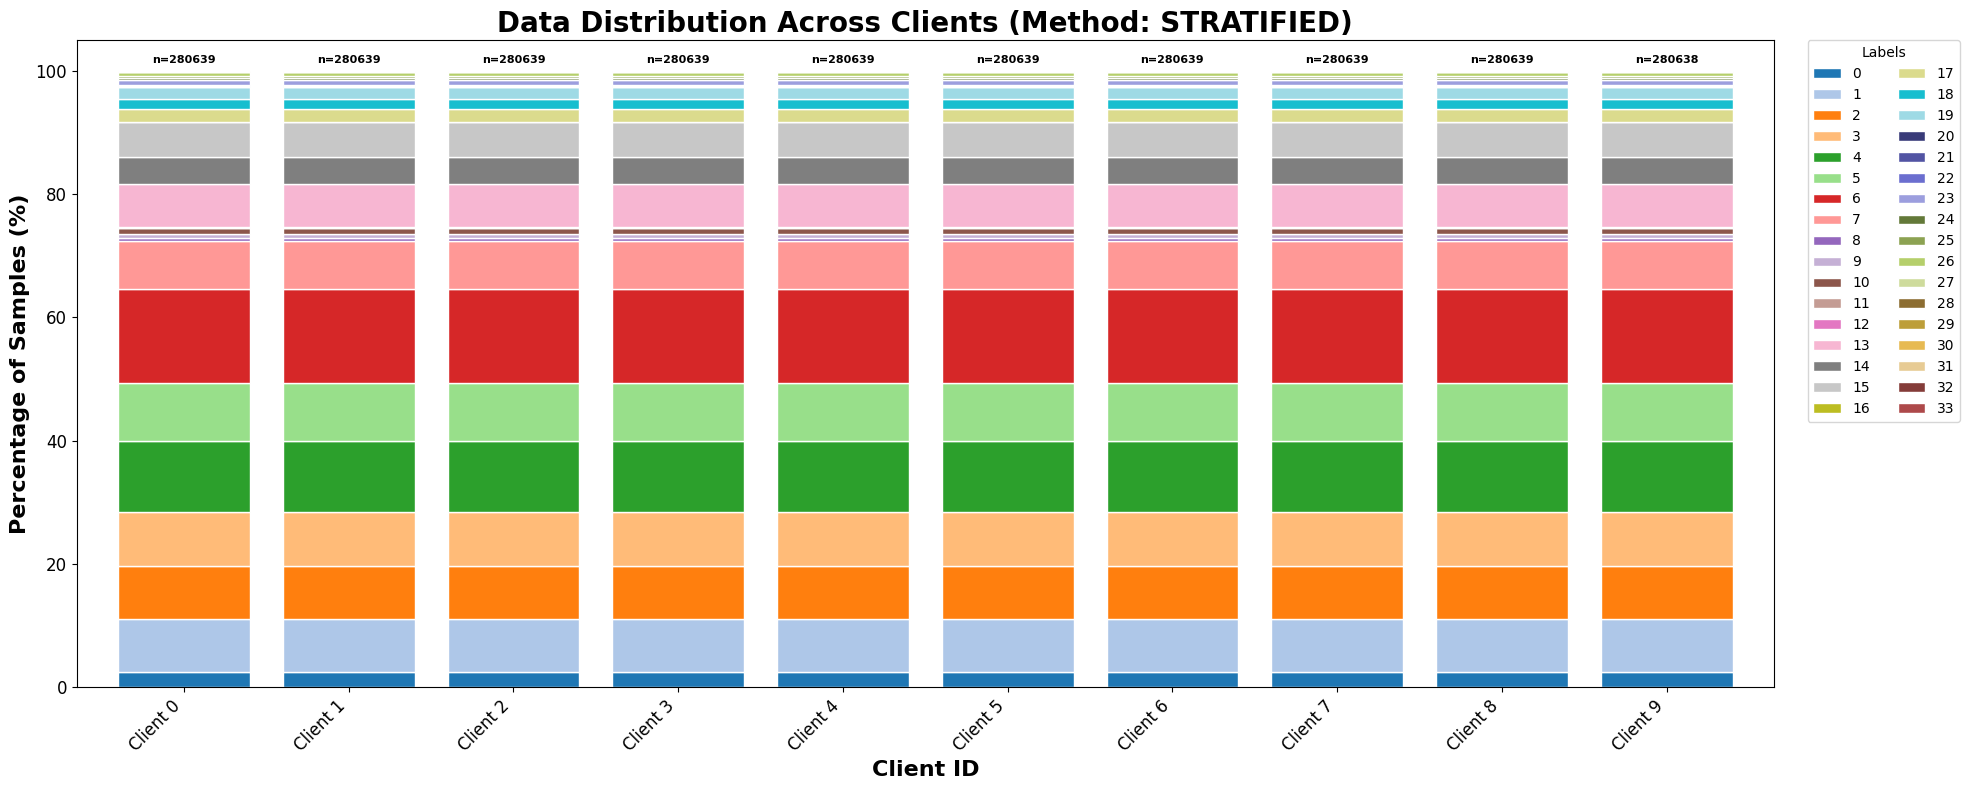

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
client_distributions = {}
for i in range(NUM_OF_CLIENTS):
    # .value_counts() returns a Series, convert it to a dictionary
    client_distributions[f'Client {i}'] = fl_y_train[i].value_counts().to_dict()

# 2. Convert the dictionary to a Pandas DataFrame for easy manipulation
df_dist = pd.DataFrame(client_distributions).fillna(0).astype(int)
df_dist = df_dist.sort_index() # Sort the labels numerically for consistent colors

# 3. Plot a Stacked Bar Chart
# Convert absolute counts to percentages for the chart y-axis
df_percent = df_dist.divide(df_dist.sum(axis=0), axis=1) * 100

# Create a diverse color palette to ensure distinct colors for all 34 labels
# We combine multiple colormaps to get enough unique colors
colors1 = plt.cm.get_cmap('tab20', 20)
colors2 = plt.cm.get_cmap('tab20b', 20)
colors = np.vstack((colors1.colors, colors2.colors))

# Plot the chart with a much wider figure size
ax = df_percent.T.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 8), # Increased width for readability
    color=colors,
    width=0.8,
    edgecolor="white"
)

# 4. Customize the plot for better presentation
plt.title(f'Data Distribution Across Clients (Method: {METHOD})', fontsize=20, fontweight='bold')
plt.xlabel('Client ID', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Samples (%)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.yticks(fontsize=12)
plt.ylim(0, 105) # Add a little space at the top for annotations

# Move the legend outside the plot and arrange it in 2 columns
plt.legend(
    title='Labels',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='medium',
    ncol=2 # Arrange legend in two columns
)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add total sample count (n=...) above each bar for context
for i, total in enumerate(df_dist.sum(axis=0)):
    ax.text(i, 101, f'n={total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

#  plt.show()

Prepare an output directory where we can store the results of the federated learning

In [ ]:
# Create an "Output" directory if it doesnt exist already
if not os.path.exists("Output"):
    os.makedirs("Output")

sub_dir_name = f"train_size-{train_size}"

# if sub_dir_name does not exist, create it
if not os.path.exists(f"Output/{sub_dir_name}"):
    os.makedirs(f"Output/{sub_dir_name}")

test_directory_name = f"{METHOD}_Classifier-{class_size}_Clients-{NUM_OF_CLIENTS}"
output_path = f"Output/{sub_dir_name}/{test_directory_name}" # Lưu lại đường dẫn để dùng sau

# Create an "Output/{METHOD}-{NUM_OF_CLIENTS}-{NUM_OF_ROUNDS}" directory if it doesnt exist already
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Ensure the directory is empty
for file in os.listdir(output_path):
    file_path = os.path.join(output_path, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)

# Original training size is the sum of all the fl_X_train sizes
original_training_size = 0
for i in range(len(fl_X_train)):
    original_training_size += fl_X_train[i].shape[0]

# Write this same info to the output directory/Class Split Info.txt
with open(f"{output_path}/Class Split Info.txt", "w") as f:
    for i in range(len(fl_X_train)):
        f.write(f"Client ID: {i}\n")
        f.write(f"fl_X_train.shape: {fl_X_train[i].shape}\n")
        f.write(f"Training data used {original_training_size}\n")
        f.write(f"fl_y_train.value_counts():\n{fl_y_train[i].value_counts().to_string()}\n")
        f.write(f"fl_y_train.unique(): {fl_y_train[i].unique()}\n\n")

print(f"Output directory and summary file created at: {output_path}")

Output directory and summary file created at: Output/train_size-2806456/STRATIFIED_Classifier-34_Clients-10


Convert the training dataset


In [ ]:
# Convert the testing dataframe to numpy arrays for TensorFlow/Keras
X_test = test_df[X_columns].to_numpy()
y_test = test_df[y_column].to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Determine the number of unique classes in the target column
num_unique_classes = len(train_df[y_column].unique())

# Store the shapes of the original dataframes for logging purposes before deleting them
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Now that we have fl_X_train, fl_y_train, X_test, and y_test extracted,
# we can safely delete the large dataframes to free up memory
if 'train_df' in locals():
    del train_df
if 'test_df' in locals():
    del test_df
if 'client_df' in locals():
    del client_df
print("Final data conversion to numpy complete. Dataframes deleted to free up memory.")

Final data conversion to numpy complete. Dataframes deleted to free up memory.


Data check

In [ ]:
print("NUM_CLIENTS:", NUM_OF_CLIENTS)

print("NUM_ROUNDS:", NUM_OF_ROUNDS)
print()


print("Original training size: {}".format(original_training_size))


print("Checking training data split groups")
for i in range(len(fl_X_train)):
    print(i, ":", "X Shape", fl_X_train[i].shape, "Y Shape", fl_y_train[i].shape)


# Print the sizes of X_test and y_test
print("\nChecking testing data")
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

print("\nDeploy Simulation")

NUM_CLIENTS: 10
NUM_ROUNDS: 10

Original training size: 2806389
Checking training data split groups
0 : X Shape (280639, 39) Y Shape (280639,)
1 : X Shape (280639, 39) Y Shape (280639,)
2 : X Shape (280639, 39) Y Shape (280639,)
3 : X Shape (280639, 39) Y Shape (280639,)
4 : X Shape (280639, 39) Y Shape (280639,)
5 : X Shape (280639, 39) Y Shape (280639,)
6 : X Shape (280639, 39) Y Shape (280639,)
7 : X Shape (280639, 39) Y Shape (280639,)
8 : X Shape (280639, 39) Y Shape (280639,)
9 : X Shape (280638, 39) Y Shape (280638,)

Checking testing data
X_test size: (744790, 39)
y_test size: (744790,)

Deploy Simulation


In [ ]:
print("X_test min/max/mean:", np.min(X_test), np.max(X_test), np.mean(X_test))
print("Client 0 X min/max/mean:", np.min(fl_X_train[0]), np.max(fl_X_train[0]), np.mean(fl_X_train[0]))

X_test min/max/mean: -52.92539879493338 476.80242930958366 -0.000634890663062242
Client 0 X min/max/mean: -52.92539879493338 787.3488761691207 -6.461840611824633e-05


#Federated Learning

Import the libraries and print the versions


In [ ]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


Define the Client and Server code

In [ ]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

print('scikit-learn {}.'.format(sklearn.__version__))
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import datetime

client_evaluations = []

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")
        self.model.fit(self.train_data, self.train_labels, epochs=1, batch_size=32)
        print ("Client ", self.cid, "Training complete...")
        return self.model.get_weights(), len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print(f"{Colours.YELLOW.value}Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}{Colours.NORMAL.value}")

        # Write the same message to the "Output/{cid}_Evaluation.txt" file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/{self.cid}_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}\n")

            # Close the file
            f.close()

        return loss, len(self.train_data), {"accuracy": accuracy}

    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Dense(50, activation='relu', input_shape=(fl_X_train[0].shape[1],)),
      Dense(25, activation='relu'),
      Dense(num_unique_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
eval_count = 0

def get_evaluate_fn(server_model):
    global eval_count

    def evaluate(server_round, parameters, config):
        global eval_count

        # Update model weights from the latest client parameters
        server_model.set_weights(parameters)
        print(f"Server Evaluating... Evaluation Count: {eval_count}")

        # Evaluate the model on the test set
        loss, accuracy = server_model.evaluate(X_test, y_test)

        # Record accuracy and loss for visualization or tracking
        server_accuracy_history.append(accuracy)
        server_loss_history.append(loss)

        # Make predictions and save them to a file
        y_pred = server_model.predict(X_test)
        print("Prediction: ", y_pred, y_pred.shape)
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)

        # Print evaluation result to console
        print(f"{Colours.YELLOW.value}Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}{Colours.NORMAL.value}")

        # Write evaluation log to file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/Server_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - {server_round} : Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}\n")

        # Increment evaluation counter
        eval_count += 1

        return loss, {"accuracy": accuracy}

    return evaluate



scikit-learn 1.6.1.
flwr 1.20.0
numpy 2.0.2
tf 2.19.0


Initialize Server Model and Strategy

In [ ]:
from flwr.server.strategy import FedAdagrad

from flwr.common import ndarrays_to_parameters
server_model = Sequential([
    #Flatten(input_shape=(79,1)),
    Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(num_unique_classes, activation='softmax')
])


server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initial_weights = server_model.get_weights()
initial_parameters = ndarrays_to_parameters(initial_weights)

# Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10, #10,
#         min_evaluate_clients=5, #5,
#         min_available_clients=10, #10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         #evaluate_metrics_aggregation_fn=weighted_average,
# )

# Test FedAdam
# strategy = fl.server.strategy.FedAdam(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         eta=1.0,           # Server-side learning rate
#         beta_1=0.9,
#         beta_2=0.999,
#         tau=1e-9,
#         initial_parameters=initial_parameters
# )

strategy = FedAdagrad(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_OF_CLIENTS,
        initial_parameters=initial_parameters,
        evaluate_fn=get_evaluate_fn(server_model),
    )

# Define FedProx strategy
# strategy = FedProx(
#     proximal_mu=1.0,  # Proximal term coefficient (tune as needed)
#     fraction_fit=1.0,  # Fraction of clients to sample for training
#     fraction_evaluate=1.0,  # Fraction of clients to sample for evaluation
#     min_fit_clients=NUM_OF_CLIENTS,  # Minimum number of clients for training
#     min_evaluate_clients=NUM_OF_CLIENTS,  # Minimum number of clients for evaluation
#     min_available_clients=NUM_OF_CLIENTS,  # Minimum number of available clients
#     evaluate_fn=get_evaluate_fn(server_model),
# )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Deploy Simulation

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout



Deploy simulation... Method = STRATIFIED - Individual (34) Classifier
Number of Clients = 10

Writing output to: train_size-2806456/STRATIFIED_Classifier-34_Clients-10



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-08-23 06:28:35,254	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 4002215116.0, 'node:172.28.0.12': 1.0, 'memory': 8004430235.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


Server Evaluating... Evaluation Count: 0
 1948/23275 ━━━━━━━━━━━━━━━━━━━━ 1:02 3ms/step - accuracy: 3.4410e-04 - loss: 3.6201

(pid=33922) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=33922) E0000 00:00:1755930527.013214   33922 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=33922) E0000 00:00:1755930527.089062   33922 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 2257/23275 ━━━━━━━━━━━━━━━━━━━━ 1:01 3ms/step - accuracy: 3.3164e-04 - loss: 3.6203

(pid=33923) W0000 00:00:1755930527.928054   33923 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=33923) W0000 00:00:1755930527.928139   33923 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=33923) W0000 00:00:1755930527.928147   33923 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=33923) W0000 00:00:1755930527.928152   33923 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.


23275/23275 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 2.6126e-04 - loss: 3.6192
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step


INFO :      initial parameters (loss, other metrics): 3.6190402507781982, {'accuracy': 0.0002470494946464896}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)


Prediction:  [[0.04528253 0.01992991 0.03287967 ... 0.05218826 0.01856518 0.02705454]
 [0.04441916 0.01890133 0.02788763 ... 0.04094222 0.01476916 0.00627931]
 [0.04403732 0.02555188 0.03010166 ... 0.03399408 0.02979138 0.01591749]
 ...
 [0.05870406 0.01086934 0.02379583 ... 0.02357371 0.0082187  0.01088456]
 [0.03622769 0.02414721 0.03083369 ... 0.03513193 0.02813174 0.03202195]
 [0.03707334 0.02312349 0.03104116 ... 0.03647624 0.02628549 0.03050684]] (744790, 34)
Server evaluation complete - Accuracy: 0.0002, Loss: 3.6190


(ClientAppActor pid=33923) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=33923) 
(ClientAppActor pid=33923)             This is a deprecated feature. It will be removed
(ClientAppActor pid=33923)             entirely in future versions of Flower.
(ClientAppActor pid=33923)         
(ClientAppActor pid=33923) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=33923)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(pid=33923) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=33923

(ClientAppActor pid=33923) Client ID: 6


(ClientAppActor pid=33923) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=33923) Client  6 Training...


(ClientAppActor pid=33922) 
(ClientAppActor pid=33922)         


   6/8770 ━━━━━━━━━━━━━━━━━━━━ 1:28 10ms/step - accuracy: 0.0000e+00 - loss: 3.5832 
  38/8770 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.0508 - loss: 3.3932
  70/8770 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.1488 - loss: 3.2330
 105/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.2264 - loss: 3.0254
(ClientAppActor pid=33922) Client ID: 7
 145/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.2896 - loss: 2.7982
 183/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.3346 - loss: 2.6144
 220/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.3689 - loss: 2.4614
 248/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.3909 - loss: 2.3607
  45/8770 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.0563 - loss: 3.3582
 278/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.4112 - loss: 2.2653
(ClientAppActor pid=33922) Client  7 Training...
 441/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.4766 - loss: 1.9218
 459/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - 

(ClientAppActor pid=33922) 
(ClientAppActor pid=33922)         
(ClientAppActor pid=33922) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=33922)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=33922)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=33922) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=33922)   super().__init__(activity_regularizer=activity_regularizer, **k

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 2:44:59 1s/step - accuracy: 0.0000e+00 - loss: 3.6809
  61/8770 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.1303 - loss: 3.2821
8762/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7080 - loss: 0.6914 [repeated 29x across cluster]
  91/8770 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.2041 - loss: 3.1189
 105/8770 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.2302 - loss: 3.0417
 133/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.2756 - loss: 2.8896
 164/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.3168 - loss: 2.7326
 194/8770 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.3491 - loss: 2.5978
 236/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.3854 - loss: 2.4365
 274/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.4118 - loss: 2.3128
 307/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.4310 - loss: 2.2197
 345/8770 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4498 - loss: 2.1256
 376/8770 ━━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 3 results and 0 failures


8745/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7072 - loss: 0.7011
Server Evaluating... Evaluation Count: 1
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7072 - loss: 0.7007
(ClientAppActor pid=33922) Client  5 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.6571 - loss: 1.0951
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step
Prediction:  [[1.8989642e-03 1.6120550e-03 6.6240998e-03 ... 8.3452212e-03
  3.7017415e-04 5.5907312e-04]
 [5.7735164e-03 2.6713355e-02 2.8134519e-01 ... 1.0569347e-03
  2.8881421e-03 1.2023888e-03]
 [6.0530170e-03 6.6360431e-03 9.4815595e-03 ... 3.8165526e-04
  6.1574657e-03 9.2036695e-05]
 ...
 [2.4980590e-02 7.2172610e-03 4.6235886e-03 ... 5.8306614e-04
  4.4602450e-04 4.4562127e-03]
 [2.7633566e-02 3.3277867e-03 2.2446534e-02 ... 1.4357310e-02
  3.0926757e-03 7.0116092e-03]
 [2.7868195e-02 3.5038269e-03 2.5169382e-02 ... 1.7032214e-02
  3.4578859e-03 7.1744891e-03]] (744790, 34)


INFO :      fit progress: (1, 1.0935053825378418, {'accuracy': 0.658372163772583}, 200.70605453900043)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server evaluation complete - Accuracy: 0.6584, Loss: 1.0935
(ClientAppActor pid=33922) Client ID: 9
(ClientAppActor pid=33922) Client  9 Evaluating...


(ClientAppActor pid=33922) 
(ClientAppActor pid=33922)         
(ClientAppActor pid=33922) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=33922)             This is a deprecated feature. It will be removed
(ClientAppActor pid=33922)             entirely in future versions of Flower.
(ClientAppActor pid=33922) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=33922)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=33922) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

  21/8770 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.7116 - loss: 1.0014      
  56/8770 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6878 - loss: 1.0367
  95/8770 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6774 - loss: 1.0536
 136/8770 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6709 - loss: 1.0665
 322/8770 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6585 - loss: 1.0847
 925/8770 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6578 - loss: 1.0969
(ClientAppActor pid=33923) Client ID: 1
(ClientAppActor pid=33923) Client  1 Evaluating...
  21/8770 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6625 - loss: 1.0732      
1541/8770 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6562 - loss: 1.0922 [repeated 88x across cluster]
1879/8770 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.6578 - loss: 1.0954
1650/8770 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.6563 - loss: 1.0924 [repeated 5x across cluster]
2087/8770 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.

(ClientAppActor pid=33922) 
(ClientAppActor pid=33922)         
(ClientAppActor pid=33923) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=33922) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=33922)             This is a deprecated feature. It will be removed
(ClientAppActor pid=33922)             entirely in future versions of Flower.
(ClientAppActor pid=33922) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the fi

  37/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6649 - loss: 1.0809      
 106/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6640 - loss: 1.0724
 163/8770 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6612 - loss: 1.0758
 227/8770 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6594 - loss: 1.0793
 297/8770 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6589 - loss: 1.0813
 363/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6587 - loss: 1.0826
 430/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6587 - loss: 1.0833
 496/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6589 - loss: 1.0838
 565/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6590 - loss: 1.0842
 631/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6590 - loss: 1.0845
 701/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6589 - loss: 1.0850
 767/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6589 - loss: 1.0853
 822/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)


8739/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6591 - loss: 1.0924
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6590 - loss: 1.0924
(ClientAppActor pid=33922) Client 2 evaluation complete - Accuracy: 0.658084, Loss: 1.095381
(ClientAppActor pid=33922) Client ID: 5
(ClientAppActor pid=33922) Client  5 Training...


(ClientAppActor pid=33922) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=33922) 
(ClientAppActor pid=33922)             This is a deprecated feature. It will be removed
(ClientAppActor pid=33922)             entirely in future versions of Flower.
(ClientAppActor pid=33922)         
(ClientAppActor pid=33922) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=33922)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=33922) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 5:27:20 2s/step - accuracy: 0.6875 - loss: 1.2628
  16/8770 ━━━━━━━━━━━━━━━━━━━━ 1:01 7ms/step - accuracy: 0.6825 - loss: 1.0531
  32/8770 ━━━━━━━━━━━━━━━━━━━━ 1:02 7ms/step - accuracy: 0.6837 - loss: 0.9720
  37/8770 ━━━━━━━━━━━━━━━━━━━━ 1:07 8ms/step - accuracy: 0.6846 - loss: 0.9560
  46/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 7ms/step - accuracy: 0.6866 - loss: 0.9301
  53/8770 ━━━━━━━━━━━━━━━━━━━━ 1:04 7ms/step - accuracy: 0.6888 - loss: 0.9118
  70/8770 ━━━━━━━━━━━━━━━━━━━━ 1:01 7ms/step - accuracy: 0.6940 - loss: 0.8752
  79/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.6959 - loss: 0.8599
  98/8770 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.6988 - loss: 0.8340
 111/8770 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.7008 - loss: 0.8189
 140/8770 ━━━━━━━━━━━━━━━━━━━━ 1:00 7ms/step - accuracy: 0.7038 - loss: 0.7933
 164/8770 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.7056 - loss: 0.7757 
 124/8770 ━━━━━━━━━━━━━━━━━━━━ 1:08 8ms/step - accur

(ClientAppActor pid=33922) 
(ClientAppActor pid=33922)         
(ClientAppActor pid=33922) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=33922)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=33922)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=33922) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=33922)   super().__init__(activity_regularizer=activity_regularizer, **k

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 2:46:37 1s/step - accuracy: 0.5625 - loss: 1.1571
  53/8770 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6652 - loss: 0.9107
 108/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6831 - loss: 0.8209
 161/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6925 - loss: 0.7740
 215/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7004 - loss: 0.7411
 268/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7045 - loss: 0.7186
 323/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7079 - loss: 0.7000
 378/8770 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7105 - loss: 0.6849
 432/8770 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7124 - loss: 0.6732
 470/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7133 - loss: 0.6661
 523/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7145 - loss: 0.6575
 549/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7150 - loss: 0.6537
 604/8770 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.715

INFO :      aggregate_fit: received 3 results and 0 failures


8750/8770 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7369 - loss: 0.5293
Server Evaluating... Evaluation Count: 2
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.7370 - loss: 0.5292
(ClientAppActor pid=33922) Client  1 Training complete...
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.6794 - loss: 0.6669
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step
Prediction:  [[4.3821472e-04 5.8553607e-04 9.1967476e-04 ... 1.5320474e-03
  5.9283349e-05 1.4143268e-04]
 [1.0248998e-04 3.5232177e-03 8.3485240e-01 ... 3.5904392e-05
  4.7858537e-04 2.1284938e-04]
 [1.2390285e-03 2.3596643e-03 3.1269062e-03 ... 1.0451592e-04
  1.3836699e-03 2.8911003e-05]
 ...
 [3.0473890e-03 1.6761207e-03 9.5623598e-04 ... 3.1760985e-05
  1.3307833e-04 3.3102572e-04]
 [8.5538868e-03 8.9079411e-05 2.2081002e-03 ... 2.4071003e-03
  2.4380018e-04 2.1277033e-03]
 [7.7880598e-03 1.1725475e-04 3.0159494e-03 ... 3.1229414e-03
  3.6105086e-04 2.1863983e-03]] (744790, 34)


INFO :      fit progress: (2, 0.6661880612373352, {'accuracy': 0.679780900478363}, 451.0944615240005)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server evaluation complete - Accuracy: 0.6798, Loss: 0.6662
(ClientAppActor pid=33922) Client ID: 7
(ClientAppActor pid=33922) Client  7 Evaluating...


(ClientAppActor pid=33922) 
(ClientAppActor pid=33922)         
(ClientAppActor pid=33922) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=33922)             This is a deprecated feature. It will be removed
(ClientAppActor pid=33922)             entirely in future versions of Flower.
(ClientAppActor pid=33922) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=33922)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=33922) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

   1/8770 ━━━━━━━━━━━━━━━━━━━━ 1:27:30 599ms/step - accuracy: 0.6250 - loss: 0.8355
  43/8770 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6858 - loss: 0.6778
  89/8770 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6822 - loss: 0.6750
 132/8770 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6793 - loss: 0.6775
 178/8770 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6799 - loss: 0.6763
 224/8770 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6798 - loss: 0.6750
 465/8770 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6787 - loss: 0.6722
1040/8770 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6779 - loss: 0.6698
(ClientAppActor pid=33923) Client ID: 9
(ClientAppActor pid=33923) Client  9 Evaluating...
   1/8770 ━━━━━━━━━━━━━━━━━━━━ 1:22:30 564ms/step - accuracy: 0.7812 - loss: 0.5707
  32/8770 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7232 - loss: 0.6419
1934/8770 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6775 - loss: 0.6693 [repeated 87x across cluster]
2091/8770

(ClientAppActor pid=33923) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=33923) 
(ClientAppActor pid=33923)             This is a deprecated feature. It will be removed
(ClientAppActor pid=33923)             entirely in future versions of Flower.
(ClientAppActor pid=33923)         
(ClientAppActor pid=33923) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=33923)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=33923) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=33923) Client ID: 6
(ClientAppActor pid=33923) Client  6 Evaluating...
   1/8770 ━━━━━━━━━━━━━━━━━━━━ 51:46 354ms/step - accuracy: 0.8438 - loss: 0.4941
  61/8770 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7028 - loss: 0.6476
  96/8770 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7024 - loss: 0.6454
 165/8770 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7003 - loss: 0.6453
 234/8770 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7000 - loss: 0.6450
 304/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6989 - loss: 0.6458
 371/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6977 - loss: 0.6470
 444/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6965 - loss: 0.6482
 509/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6954 - loss: 0.6495
 580/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6942 - loss: 0.6511
 651/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6931 - loss: 0.6525
 708/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - a

INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)


(ClientAppActor pid=33923) Client 6 evaluation complete - Accuracy: 0.679521, Loss: 0.667173


(ClientAppActor pid=33923) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=33923) 
(ClientAppActor pid=33923)             This is a deprecated feature. It will be removed
(ClientAppActor pid=33923)             entirely in future versions of Flower.
(ClientAppActor pid=33923)         
(ClientAppActor pid=33923) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=33923)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=33923) Client ID: 0


(ClientAppActor pid=33923) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=33923) Client  0 Training...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

  26/8770 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.7115 - loss: 0.6160    
8770/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6808 - loss: 0.6656 [repeated 16x across cluster]
  80/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7324 - loss: 0.5721
 123/8770 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7376 - loss: 0.5572
 177/8770 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.7396 - loss: 0.5475
 233/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7403 - loss: 0.5424
 285/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7408 - loss: 0.5395
 340/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7409 - loss: 0.5371
 393/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7408 - loss: 0.5356
 418/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7408 - loss: 0.5350
 472/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7408 - loss: 0.5339
 523/8770 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7407 - loss: 0.5328
 579/8770 ━━━━━━━━━━━━━━━━━━━━

(raylet) [2025-08-23 06:39:35,202 E 33766 33766] (raylet) node_manager.cc:3064: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: cbd942f9ae54a6fb0f965a3c4677239463723c9a0e24b17459add7cf, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


3995/8770 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7427 - loss: 0.5105
4032/8770 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7428 - loss: 0.5104
4089/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7428 - loss: 0.5102
4141/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7428 - loss: 0.5101
4197/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7428 - loss: 0.5100
4248/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7428 - loss: 0.5099
4302/8770 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7428 - loss: 0.5098
4354/8770 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7428 - loss: 0.5097
4411/8770 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7428 - loss: 0.5096
4467/8770 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7429 - loss: 0.5095
4554/8770 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7429 - loss: 0.5093
4597/8770 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7429 - loss: 0.5093
4651/8770 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7429 -

INFO :      aggregate_fit: received 1 results and 2 failures


8770/8770 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.7446 - loss: 0.5036
(ClientAppActor pid=33923) Client  0 Training complete...
Server Evaluating... Evaluation Count: 3
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.7214 - loss: 0.5695
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step
Prediction:  [[1.61046817e-04 2.75631231e-04 2.20458111e-04 ... 5.97061880e-04
  1.14325858e-05 2.12221748e-05]
 [8.74096258e-06 3.84281011e-04 8.98346484e-01 ... 3.46215734e-06
  1.04210805e-04 2.72064353e-05]
 [4.43631609e-04 2.91144854e-04 1.26716320e-03 ... 2.67436571e-05
  1.83031123e-04 8.29343026e-06]
 ...
 [8.88931740e-04 2.04538650e-04 8.80373176e-04 ... 1.24528297e-05
  7.06398932e-05 2.87493574e-04]
 [1.70361763e-03 1.45368967e-05 5.98888379e-04 ... 4.56634880e-04
  7.50908584e-05 4.14354494e-04]
 [1.48290838e-03 2.19067806e-05 8.59400083e-04 ... 6.81071833e-04
  1.26216997e-04 3.84827232e-04]] (744790, 34)


INFO :      fit progress: (3, 0.5691842436790466, {'accuracy': 0.7218142151832581}, 626.4053238180004)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server evaluation complete - Accuracy: 0.7218, Loss: 0.5692


(ClientAppActor pid=33923) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=33923) 
(ClientAppActor pid=33923)             This is a deprecated feature. It will be removed
(ClientAppActor pid=33923)             entirely in future versions of Flower.
(ClientAppActor pid=33923)         
(ClientAppActor pid=33923) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=33923)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=33923) WARNING :   Deprecation Warning: The `client_fn` function must return an instance 

(ClientAppActor pid=33923) Client ID: 2
(ClientAppActor pid=33923) Client  2 Evaluating...


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Server Evaluating... Evaluation Count: 4
 5854/23275 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.7211 - loss: 0.5698

(raylet) [2025-08-23 06:41:35,207 E 33766 33766] (raylet) node_manager.cc:3064: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: cbd942f9ae54a6fb0f965a3c4677239463723c9a0e24b17459add7cf, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


23275/23275 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - accuracy: 0.7214 - loss: 0.5695
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step
Prediction:  [[1.61046817e-04 2.75631231e-04 2.20458111e-04 ... 5.97061880e-04
  1.14325858e-05 2.12221748e-05]
 [8.74096258e-06 3.84281011e-04 8.98346484e-01 ... 3.46215734e-06
  1.04210805e-04 2.72064353e-05]
 [4.43631609e-04 2.91144854e-04 1.26716320e-03 ... 2.67436571e-05
  1.83031123e-04 8.29343026e-06]
 ...
 [8.88931740e-04 2.04538650e-04 8.80373176e-04 ... 1.24528297e-05
  7.06398932e-05 2.87493574e-04]
 [1.70361763e-03 1.45368967e-05 5.98888379e-04 ... 4.56634880e-04
  7.50908584e-05 4.14354494e-04]
 [1.48290838e-03 2.19067806e-05 8.59400083e-04 ... 6.81071833e-04
  1.26216997e-04 3.84827232e-04]] (744790, 34)


INFO :      fit progress: (4, 0.5691842436790466, {'accuracy': 0.7218142151832581}, 725.9772230420003)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server evaluation complete - Accuracy: 0.7218, Loss: 0.5692


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Server Evaluating... Evaluation Count: 5
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.7214 - loss: 0.5695
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step
Prediction:  [[1.61046817e-04 2.75631231e-04 2.20458111e-04 ... 5.97061880e-04
  1.14325858e-05 2.12221748e-05]
 [8.74096258e-06 3.84281011e-04 8.98346484e-01 ... 3.46215734e-06
  1.04210805e-04 2.72064353e-05]
 [4.43631609e-04 2.91144854e-04 1.26716320e-03 ... 2.67436571e-05
  1.83031123e-04 8.29343026e-06]
 ...
 [8.88931740e-04 2.04538650e-04 8.80373176e-04 ... 1.24528297e-05
  7.06398932e-05 2.87493574e-04]
 [1.70361763e-03 1.45368967e-05 5.98888379e-04 ... 4.56634880e-04
  7.50908584e-05 4.14354494e-04]
 [1.48290838e-03 2.19067806e-05 8.59400083e-04 ... 6.81071833e-04
  1.26216997e-04 3.84827232e-04]] (744790, 34)


INFO :      fit progress: (5, 0.5691842436790466, {'accuracy': 0.7218142151832581}, 822.0384151540002)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server evaluation complete - Accuracy: 0.7218, Loss: 0.5692


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Server Evaluating... Evaluation Count: 6
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - accuracy: 0.7214 - loss: 0.5695
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step
Prediction:  [[1.61046817e-04 2.75631231e-04 2.20458111e-04 ... 5.97061880e-04
  1.14325858e-05 2.12221748e-05]
 [8.74096258e-06 3.84281011e-04 8.98346484e-01 ... 3.46215734e-06
  1.04210805e-04 2.72064353e-05]
 [4.43631609e-04 2.91144854e-04 1.26716320e-03 ... 2.67436571e-05
  1.83031123e-04 8.29343026e-06]
 ...
 [8.88931740e-04 2.04538650e-04 8.80373176e-04 ... 1.24528297e-05
  7.06398932e-05 2.87493574e-04]
 [1.70361763e-03 1.45368967e-05 5.98888379e-04 ... 4.56634880e-04
  7.50908584e-05 4.14354494e-04]
 [1.48290838e-03 2.19067806e-05 8.59400083e-04 ... 6.81071833e-04
  1.26216997e-04 3.84827232e-04]] (744790, 34)


INFO :      fit progress: (6, 0.5691842436790466, {'accuracy': 0.7218142151832581}, 960.4985321010008)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server evaluation complete - Accuracy: 0.7218, Loss: 0.5692


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Server Evaluating... Evaluation Count: 7
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.7214 - loss: 0.5695
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step
Prediction:  [[1.61046817e-04 2.75631231e-04 2.20458111e-04 ... 5.97061880e-04
  1.14325858e-05 2.12221748e-05]
 [8.74096258e-06 3.84281011e-04 8.98346484e-01 ... 3.46215734e-06
  1.04210805e-04 2.72064353e-05]
 [4.43631609e-04 2.91144854e-04 1.26716320e-03 ... 2.67436571e-05
  1.83031123e-04 8.29343026e-06]
 ...
 [8.88931740e-04 2.04538650e-04 8.80373176e-04 ... 1.24528297e-05
  7.06398932e-05 2.87493574e-04]
 [1.70361763e-03 1.45368967e-05 5.98888379e-04 ... 4.56634880e-04
  7.50908584e-05 4.14354494e-04]
 [1.48290838e-03 2.19067806e-05 8.59400083e-04 ... 6.81071833e-04
  1.26216997e-04 3.84827232e-04]] (744790, 34)


INFO :      fit progress: (7, 0.5691842436790466, {'accuracy': 0.7218142151832581}, 1056.664609683001)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server evaluation complete - Accuracy: 0.7218, Loss: 0.5692


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Server Evaluating... Evaluation Count: 8
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - accuracy: 0.7214 - loss: 0.5695
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step
Prediction:  [[1.61046817e-04 2.75631231e-04 2.20458111e-04 ... 5.97061880e-04
  1.14325858e-05 2.12221748e-05]
 [8.74096258e-06 3.84281011e-04 8.98346484e-01 ... 3.46215734e-06
  1.04210805e-04 2.72064353e-05]
 [4.43631609e-04 2.91144854e-04 1.26716320e-03 ... 2.67436571e-05
  1.83031123e-04 8.29343026e-06]
 ...
 [8.88931740e-04 2.04538650e-04 8.80373176e-04 ... 1.24528297e-05
  7.06398932e-05 2.87493574e-04]
 [1.70361763e-03 1.45368967e-05 5.98888379e-04 ... 4.56634880e-04
  7.50908584e-05 4.14354494e-04]
 [1.48290838e-03 2.19067806e-05 8.59400083e-04 ... 6.81071833e-04
  1.26216997e-04 3.84827232e-04]] (744790, 34)


INFO :      fit progress: (8, 0.5691842436790466, {'accuracy': 0.7218142151832581}, 1186.7301352329996)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server evaluation complete - Accuracy: 0.7218, Loss: 0.5692


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Server Evaluating... Evaluation Count: 9
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.7214 - loss: 0.5695
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step
Prediction:  [[1.61046817e-04 2.75631231e-04 2.20458111e-04 ... 5.97061880e-04
  1.14325858e-05 2.12221748e-05]
 [8.74096258e-06 3.84281011e-04 8.98346484e-01 ... 3.46215734e-06
  1.04210805e-04 2.72064353e-05]
 [4.43631609e-04 2.91144854e-04 1.26716320e-03 ... 2.67436571e-05
  1.83031123e-04 8.29343026e-06]
 ...
 [8.88931740e-04 2.04538650e-04 8.80373176e-04 ... 1.24528297e-05
  7.06398932e-05 2.87493574e-04]
 [1.70361763e-03 1.45368967e-05 5.98888379e-04 ... 4.56634880e-04
  7.50908584e-05 4.14354494e-04]
 [1.48290838e-03 2.19067806e-05 8.59400083e-04 ... 6.81071833e-04
  1.26216997e-04 3.84827232e-04]] (744790, 34)


INFO :      fit progress: (9, 0.5691842436790466, {'accuracy': 0.7218142151832581}, 1320.25106873)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server evaluation complete - Accuracy: 0.7218, Loss: 0.5692


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Server Evaluating... Evaluation Count: 10
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.7214 - loss: 0.5695
23275/23275 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
Prediction:  [[1.61046817e-04 2.75631231e-04 2.20458111e-04 ... 5.97061880e-04
  1.14325858e-05 2.12221748e-05]
 [8.74096258e-06 3.84281011e-04 8.98346484e-01 ... 3.46215734e-06
  1.04210805e-04 2.72064353e-05]
 [4.43631609e-04 2.91144854e-04 1.26716320e-03 ... 2.67436571e-05
  1.83031123e-04 8.29343026e-06]
 ...
 [8.88931740e-04 2.04538650e-04 8.80373176e-04 ... 1.24528297e-05
  7.06398932e-05 2.87493574e-04]
 [1.70361763e-03 1.45368967e-05 5.98888379e-04 ... 4.56634880e-04
  7.50908584e-05 4.14354494e-04]
 [1.48290838e-03 2.19067806e-05 8.59400083e-04 ... 6.81071833e-04
  1.26216997e-04 3.84827232e-04]] (744790, 34)


INFO :      fit progress: (10, 0.5691842436790466, {'accuracy': 0.7218142151832581}, 1420.4559079329993)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server evaluation complete - Accuracy: 0.7218, Loss: 0.5692


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 95, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 401, in get_client_result
    return self._fetch_future_result(cid)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 282, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
                                         ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line

Total time taken:  0:26:05.477842
SIMULATION COMPLETE. Method = STRATIFIED - Individual (34) Classifier
Number of Clients = 10



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


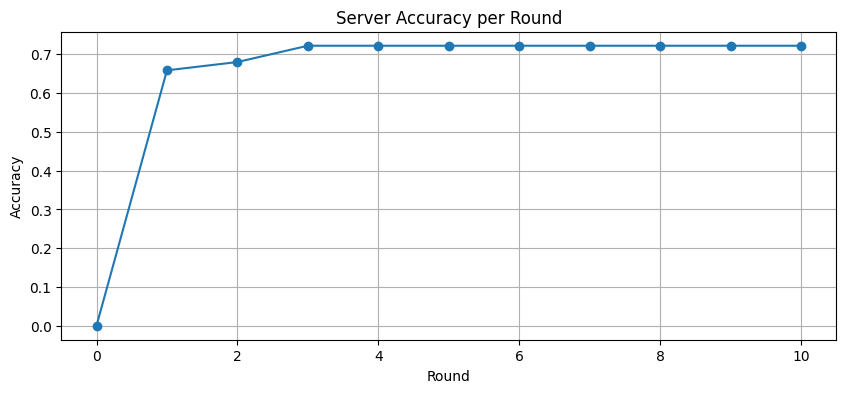

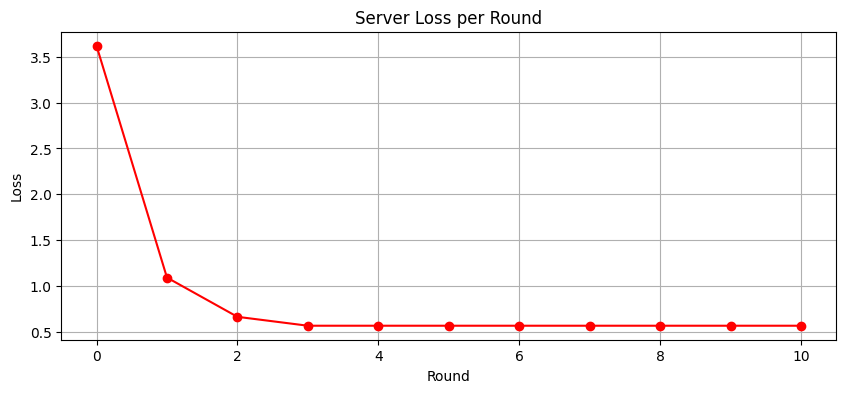

In [ ]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOG START ---
print(f"{Colours.YELLOW.value}\nDeploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}\n")
print(f"Writing output to: {sub_dir_name}/{test_directory_name}\n{Colours.NORMAL.value}")

# Ghi thông tin ban đầu vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - Deploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Number of Clients = {NUM_OF_CLIENTS}\n")
    f.write(f"{datetime.datetime.now()} - Original train_df size: {train_df_shape}\n")

    for i in range(len(fl_X_train)):
        f.write(f"{datetime.datetime.now()} - {i}: X Shape {fl_X_train[i].shape}, Y Shape {fl_y_train[i].shape}\n")

    f.write(f"{datetime.datetime.now()} - X_test size: {X_test.shape}\n")
    f.write(f"{datetime.datetime.now()} - y_test size: {y_test.shape}\n")

# --- START SIMULATION ---
start_time = datetime.datetime.now()

ray_init_args = {"num_cpus": 2}

server_accuracy_history = []
server_loss_history = []

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1},
    ray_init_args=ray_init_args,
)

end_time = datetime.datetime.now()
print("Total time taken: ", end_time - start_time)

# --- LOG END ---
print(f"{Colours.YELLOW.value}SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}{Colours.NORMAL.value}\n")

# Ghi thông tin kết thúc vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Total time taken: {end_time - start_time}\n")

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 4))
plt.plot(server_accuracy_history, marker='o')
plt.title('Server Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_accuracy_per_round.png")
plt.show()

# --- PLOT LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(server_loss_history, marker='o', color='red')
plt.title('Server Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_loss_per_round.png")
plt.show()
